In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils.genre_classification import feature_preparator
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool

In [2]:
BATCH_SIZE = 1

In [3]:
%%time
train_data_loader, test_data_loader1, test_data_loader2, idx_to_label = feature_preparator('features/genre_classification/mfcc24-zcr-sc-sr-chr-flattened.p', BATCH_SIZE)

CPU times: user 66.8 ms, sys: 16.5 ms, total: 83.3 ms
Wall time: 83.3 ms


In [4]:
features = []

features_1 = ['mean', 'std', 'skew', 'kurtosis']
features_2 = {'mfcc': 24, 'zero_crossing_rate': 1, 'spectral centroid': 1, 'spectral rollof': 1, 'chroma': 12}

for j in features_1:
    for feature, num in features_2.items():
        for i in range(num):
            features.append(f'{feature}_{i}_{j}')

In [5]:
def make_dataframe_from_dataloader(dataloader: DataLoader, column_names):
    all_features = []
    all_targets = []

    for features, target in dataloader:
        features = features.flatten()
        all_features.append(features.numpy())
        all_targets.append(target.numpy()[0])

    return pd.DataFrame.from_records(all_features, columns=column_names), pd.Series(all_targets)

def transform_idx_to_label(x):
    return idx_to_label[x]

In [6]:
train_df_x, train_df_y = make_dataframe_from_dataloader(train_data_loader, features)
test1_df_x, test1_df_y = make_dataframe_from_dataloader(test_data_loader1, features)
test2_df_x, test2_df_y = make_dataframe_from_dataloader(test_data_loader2, features)
test_df_x = pd.concat([test1_df_x, test2_df_x])
test_df_y = pd.concat([test1_df_y, test2_df_y])

Снижаем размерность

In [7]:
pca = PCA(n_components=100)

In [8]:
pca.fit(train_df_x)

PCA(n_components=100)

Сколько мы потеряли variance снизив размерность

In [9]:
1 - sum(pca.explained_variance_ratio_)

0.04489127150736749

In [10]:
train_df_x_pca = pca.transform(train_df_x)
test_df_x_pca = pca.transform(test_df_x)

In [11]:
adabooost_clf = AdaBoostClassifier(n_estimators=100, random_state=111)

In [12]:
adabooost_clf.fit(train_df_x_pca, train_df_y)

AdaBoostClassifier(n_estimators=100, random_state=111)

In [13]:
adaboost_predicted = adabooost_clf.predict(test_df_x_pca)

              precision    recall  f1-score   support

       Blues       0.36      0.35      0.35       501
   Classical       0.48      0.61      0.54       507
  Electronic       0.31      0.26      0.28       504
        Folk       0.30      0.29      0.29       498
     Hip-Hop       0.44      0.63      0.52       503
        Jazz       0.32      0.25      0.28       505
         Pop       0.17      0.08      0.11       473
        Rock       0.33      0.42      0.37       496

    accuracy                           0.36      3987
   macro avg       0.34      0.36      0.34      3987
weighted avg       0.34      0.36      0.35      3987



<AxesSubplot: >

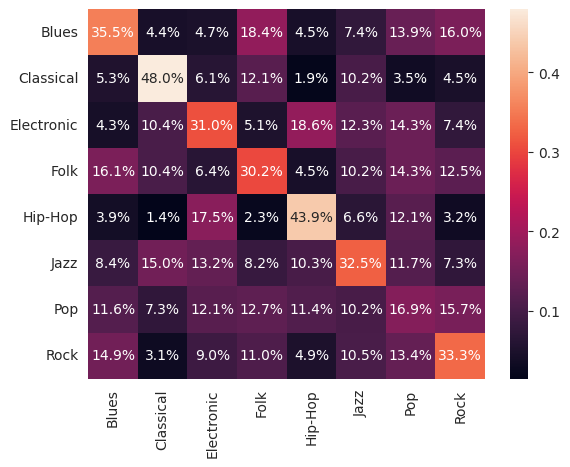

In [14]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, adaboost_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, adaboost_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%',)

In [15]:
xgb_dtrain = xgb.DMatrix(train_df_x_pca, label = train_df_y)
xgb_dtest = xgb.DMatrix(test_df_x_pca, label = test_df_y)
xgb_param = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': 8}
xgb_num_round = 100

In [16]:
xgb_clf = xgb.train(xgb_param, xgb_dtrain, xgb_num_round)
xgb_predicted_matrix = xgb_clf.predict(xgb_dtest)
xgb_predicted = np.asarray([np.argmax(line) for line in xgb_predicted_matrix])

              precision    recall  f1-score   support

       Blues       0.50      0.44      0.47       501
   Classical       0.57      0.67      0.62       507
  Electronic       0.34      0.34      0.34       504
        Folk       0.37      0.37      0.37       498
     Hip-Hop       0.52      0.63      0.57       503
        Jazz       0.40      0.38      0.39       505
         Pop       0.22      0.16      0.18       473
        Rock       0.39      0.40      0.40       496

    accuracy                           0.43      3987
   macro avg       0.41      0.42      0.42      3987
weighted avg       0.41      0.43      0.42      3987



<AxesSubplot: >

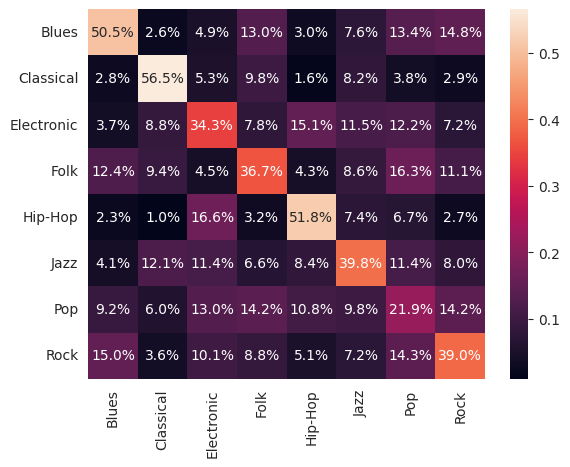

In [17]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, xgb_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, xgb_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')

In [18]:
svm_clf = SVC(gamma='auto')
svm_clf.fit(train_df_x_pca, train_df_y)
svm_predicted = svm_clf.predict(test_df_x_pca)

              precision    recall  f1-score   support

       Blues       0.59      0.44      0.50       501
   Classical       0.58      0.71      0.64       507
  Electronic       0.37      0.51      0.43       504
        Folk       0.42      0.47      0.44       498
     Hip-Hop       0.59      0.61      0.60       503
        Jazz       0.47      0.42      0.44       505
         Pop       0.30      0.16      0.20       473
        Rock       0.45      0.48      0.46       496

    accuracy                           0.48      3987
   macro avg       0.47      0.47      0.47      3987
weighted avg       0.47      0.48      0.47      3987



<AxesSubplot: >

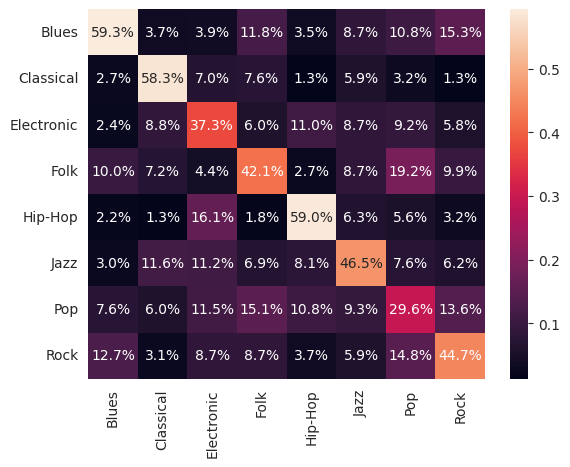

In [19]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, svm_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, svm_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')

In [20]:
cat_clf = CatBoostClassifier()
cat_clf.fit(train_df_x_pca, train_df_y)
cat_predicted = cat_clf.predict(test_df_x_pca)
cat_predicted = np.ravel(cat_predicted).tolist()

Learning rate set to 0.088659
0:	learn: 2.0264449	total: 117ms	remaining: 1m 57s
1:	learn: 1.9823591	total: 144ms	remaining: 1m 12s
2:	learn: 1.9470850	total: 172ms	remaining: 57.1s
3:	learn: 1.9195190	total: 198ms	remaining: 49.4s
4:	learn: 1.8907140	total: 228ms	remaining: 45.4s
5:	learn: 1.8711653	total: 257ms	remaining: 42.5s
6:	learn: 1.8500306	total: 286ms	remaining: 40.6s
7:	learn: 1.8272858	total: 314ms	remaining: 38.9s
8:	learn: 1.8113517	total: 342ms	remaining: 37.7s
9:	learn: 1.7971963	total: 370ms	remaining: 36.6s
10:	learn: 1.7844538	total: 397ms	remaining: 35.7s
11:	learn: 1.7696308	total: 425ms	remaining: 35s
12:	learn: 1.7588863	total: 454ms	remaining: 34.5s
13:	learn: 1.7476705	total: 482ms	remaining: 33.9s
14:	learn: 1.7387930	total: 509ms	remaining: 33.4s
15:	learn: 1.7292416	total: 537ms	remaining: 33s
16:	learn: 1.7204377	total: 566ms	remaining: 32.7s
17:	learn: 1.7112670	total: 595ms	remaining: 32.4s
18:	learn: 1.7034977	total: 622ms	remaining: 32.1s
19:	learn: 1.

              precision    recall  f1-score   support

       Blues       0.53      0.46      0.50       501
   Classical       0.57      0.66      0.61       507
  Electronic       0.38      0.40      0.39       504
        Folk       0.39      0.43      0.41       498
     Hip-Hop       0.56      0.63      0.59       503
        Jazz       0.43      0.42      0.42       505
         Pop       0.29      0.16      0.21       473
        Rock       0.42      0.46      0.44       496

    accuracy                           0.46      3987
   macro avg       0.45      0.45      0.45      3987
weighted avg       0.45      0.46      0.45      3987



<AxesSubplot: >

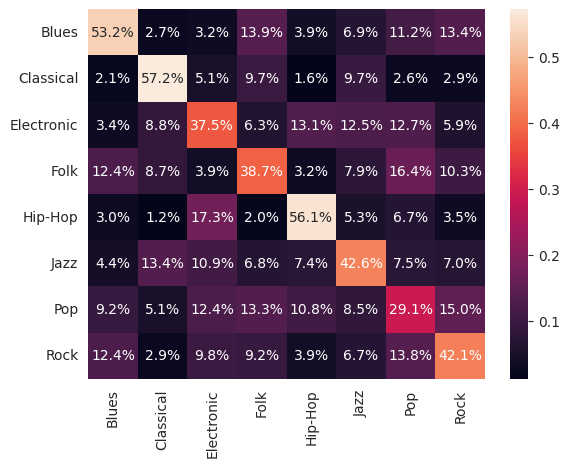

In [21]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, cat_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, cat_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')